In [1]:
# Useful information stack...


# Just change your input shape to shape=(n_channels, None, None). Where n_channels is the number of channels in your input image.

### Test for individual cell 

* Grayscale image to RGB for transfer learning
* next.. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
from platform import python_version
print("python version :", python_version()) # linux : 3.7.9 / macpro : 3.7.4
print("tensorflow version :" , tf.__version__)  # linux : 2.3.0 / macpro : 2.5.0-dev20201129
print("keras version : ", keras.__version__) # linux : 2.4.0 / macpro : 2.5.0

python version : 3.7.4
tensorflow version : 2.5.0-dev20201129
keras version :  2.5.0


In [3]:
# input image can have any size -> 500 x 500

# img_height=None
# img_width=None
img_height=500
img_width=500
batch_size=16

In [4]:
train_data=tf.keras.preprocessing.image_dataset_from_directory(
        '../data_individual_converted/', labels='inferred', label_mode=None,
        validation_split=0.2, subset='training',
        seed=1337, color_mode='rgb', image_size=(img_height, img_width),
        batch_size=batch_size        
        )

Found 669 files belonging to 2 classes.
Using 536 files for training.


In [28]:
# image=train_data.take(1)

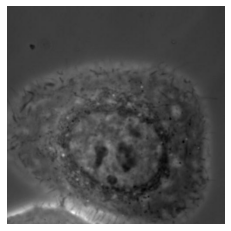

In [39]:
plt.figure(figsize=(4,4))
for image in train_data.take(1):
#     print(image[1].shape)
    plt.imshow(image[1].numpy().astype("uint8"))
    plt.axis("off")

In [6]:
val_data=tf.keras.preprocessing.image_dataset_from_directory(
        '../data_individual_converted/', labels='inferred', label_mode=None,
        validation_split=0.2, subset='validation',
        seed=1337, color_mode='grayscale', image_size=(img_height, img_width),
        batch_size=batch_size        
        )

Found 669 files belonging to 2 classes.
Using 133 files for validation.


In [7]:
class_names = train_data.class_names
print(class_names)

['par1', 'wt']


In [40]:
# https://keras.io/examples/vision/image_classification_from_scratch/
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomRotation(0.1)
    ]
)

In [42]:
inputs = keras.Input(shape=(img_height, img_width,3))
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)

In [44]:
train_ds = train_data.prefetch(buffer_size=32)
val_ds = val_data.prefetch(buffer_size=32)

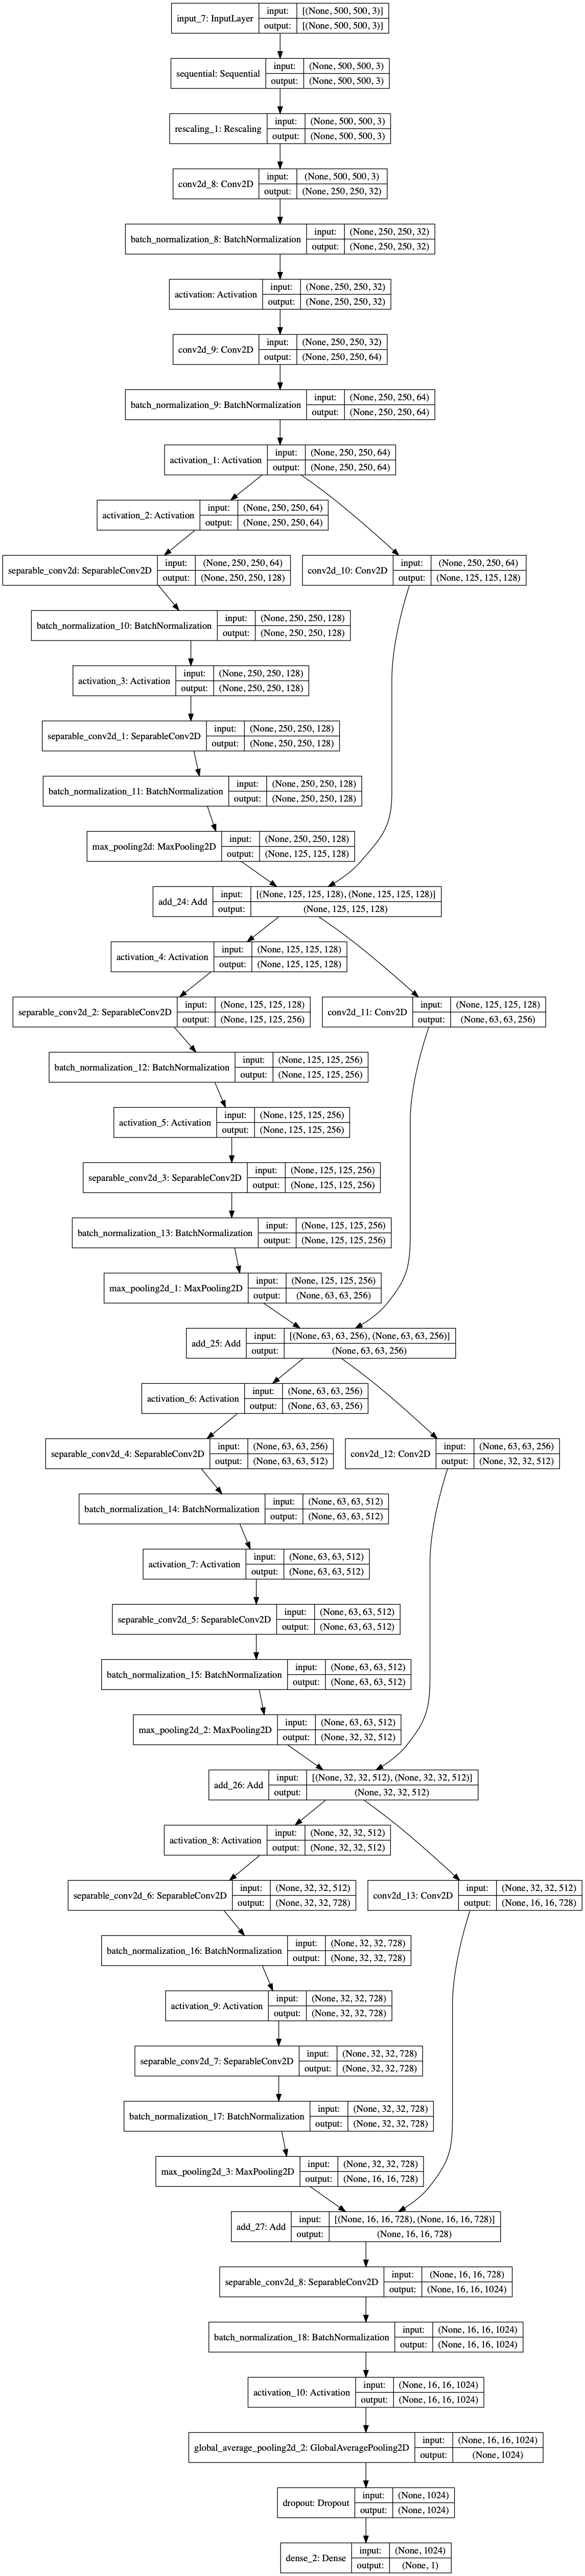

In [46]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=(img_height, img_width,3))
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


image_size=(img_height, img_width)
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [14]:
base_model = keras.applications.Xception(weights='imagenet',
                                         input_shape=(img_height, img_width,3),
                                         include_top=False)

In [15]:
base_model.trainable=False

In [16]:
inputs=keras.Input(shape=(img_height, img_width, 3))

In [17]:
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)

In [18]:
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [19]:
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=[keras.metrics.BinaryAccuracy()])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________


In [21]:
model.fit(train_data, epochs=20, validation_data=val_data)

Epoch 1/20


ValueError: in user code:

    /Users/schona/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:837 train_function  *
        return step_function(self, iterator)
    /Users/schona/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:827 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/schona/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/schona/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2731 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/schona/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3420 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/schona/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:820 run_step  **
        outputs = model.train_step(data)
    /Users/schona/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    /Users/schona/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:530 minimize
        return self.apply_gradients(grads_and_vars, name=name)
    /Users/schona/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:630 apply_gradients
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    /Users/schona/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/utils.py:79 filter_empty_gradients
        ([v.name for _, v in grads_and_vars],))

    ValueError: No gradients provided for any variable: ['dense/kernel:0', 'dense/bias:0'].


In [22]:
inputs = keras.Input(shape=(img_height,img_width,3))

norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean=np.array([127.5]*3)
var = mean**2
x = norm_layer(inputs)
norm_layer.set_weights([mean,var])

x=base_model(x, training=False)
x=keras.layers.GlobalAveragePooling2D()(x)
outputs=keras.layers.Dense(1)(x)
model=keras.Model(inputs,outputs)

In [23]:
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=[keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
normalization (Normalization (None, 500, 500, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 20,863,536
Trainable params: 2,049
Non-trainable params: 20,861,487
_________________________________________________________________


In [25]:
epochs=10
history = model.fit(train_data, validation_data=val_data, epochs=epochs)

Epoch 1/10


ValueError: in user code:

    /Users/schona/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:837 train_function  *
        return step_function(self, iterator)
    /Users/schona/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:827 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/schona/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/schona/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2731 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/schona/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3420 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/schona/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:820 run_step  **
        outputs = model.train_step(data)
    /Users/schona/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    /Users/schona/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:530 minimize
        return self.apply_gradients(grads_and_vars, name=name)
    /Users/schona/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:630 apply_gradients
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    /Users/schona/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/utils.py:79 filter_empty_gradients
        ([v.name for _, v in grads_and_vars],))

    ValueError: No gradients provided for any variable: ['dense_1/kernel:0', 'dense_1/bias:0'].
